In [0]:
from google.colab import drive
import sys
drive.mount("/content/drive")
sys.path.append("/content/drive/My Drive/SH")
import importlib
import sys
spec = importlib.util.spec_from_file_location("nf", "/content/drive/My Drive/SH/nf/__init__.py")
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x
%matplotlib inline

import tensorflow as tf
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

import itertools
from functools import partial

import clothoidlib
import importlib
importlib.reload(clothoidlib)
from nf.agents import sampling

calculator = clothoidlib.ClothoidCalculator()

DATA_DIR = Path("/content/drive/My Drive/SH/report/data")

tf.keras.backend.clear_session()
tf.__version__

'2.2.0-rc3'

In [0]:
# Radial basis activation function: e^(-x^2)
def rbf(x):
    return np.exp(-(x ** 2))

@tf.function
def rbf_tf(x):
    return tf.exp(-(x ** 2))

In [0]:
def plot_3d_space(*data, scatter = False):

    plt.figure(figsize=(12,4))

    fn = lambda ax: ax.scatter if scatter else ax.plot

    ax = plt.subplot(131)
    for d in data:
        fn(ax)(d[..., 0], d[..., 2])
    
    ax = plt.subplot(132)
    for d in data:
        fn(ax)(d[..., 0], d[..., 1])

    ax = plt.subplot(133)
    for d in data:
        fn(ax)(d[..., 1], d[..., 2])

def plot_2d_space(*data, scatter = False):
    fn = lambda ax: ax.scatter if scatter else ax.plot
    for d in data:
        fn(plt)(*d.T)

[ 0.  2. -2.]
0 [4.25160789 3.23245025 1.01915765]
1 [3.74728182 3.25451541 0.49276641]
2 [4.10620046 3.36362267 0.74257779]
3 [3.87739676 3.26671243 0.61068434]
4 [4.21891916 2.94804525 1.2708739 ]
5 [3.65189385 2.39834261 1.25355124]
6 [3.32592261 1.96118712 1.36473548]
7 [2.02602828 1.2221818  0.80384648]
8 [3.07903564 1.70154202 1.37749362]
9 [2.46630967 1.41182387 1.0544858 ]
10 [2.77725196 1.51167369 1.26557827]
11 [2.18871325 1.2288686  0.95984465]
12 [2.65772986 1.56052148 1.09720838]
13 [2.25247979 1.46431136 0.78816843]
14 [1.63995228 1.561957   0.07799528]
15 [ 0.56777096  1.80978978 -1.24201882]
16 [ 0.02348816  1.99267185 -1.96918368]
17 [ 0.00669825  2.0008347  -1.99413645]


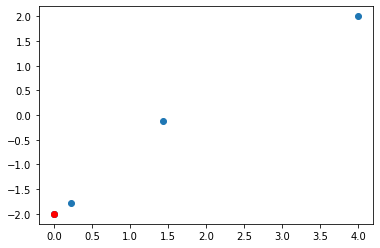

In [0]:
def get_weight_changes(num_weights: int, learning_rate: float) -> np.ndarray:
    sampler = sampling.ExhaustiveSamplingTechnique(learning_rate, uniform_radius=True)
    sampler.initialize(2)
    return sampler.weight_changes.numpy()

def calculate_clothoid(start, intermediate, goal):
    (gamma1, gamma2, alpha, beta, *_), subgoal = calculator.lookup_points(start, intermediate, goal)
    return (alpha + beta), subgoal

class Model:
    def __init__(self):
        self.X = np.array([
            (2, 2),
            (2, 0),
            (0, 2)
        ])

        self.weight_history = []
        self.output_history = []
        self.excitation_history = []
    
    def log(self, weights):
        weights = np.copy(weights)
        self.weight_history.append(weights)
        self.output_history.append(self.activation(weights))
        self.excitation_history.append(self.excitation(weights))
    
    def excitation(self, weights):
        return np.squeeze(self.X @ np.expand_dims(weights, axis=-1), axis=-1)
    
    def activation(self, weights):
        return rbf(self.excitation(weights))
    
    def gradient_descent(self, weights, goal, activation_fn):
        model = tf.keras.Sequential([tf.keras.layers.Dense(1,
                                                           use_bias=False,
                                                           activation=activation_fn,
                                                           input_shape=(2,))])
        model.set_weights([weights[:, np.newaxis]])
        model.compile(optimizer="rmsprop", loss="mse")
        model.fit(self.X, goal, epochs=1000, verbose=False)
        return np.squeeze(model.get_weights()[0], axis=-1)


    def train(self, initial_weights, goal, goal_ex, learning_rate, epochs: int = 5, k: float = .5):
        weight_changes = get_weight_changes(2, learning_rate)
        weights = initial_weights

        # 0. Initialise
        initial_ex = self.excitation(initial_weights)
        start_ex = initial_ex

        # Logging
        self.log(weights)

        # 1. Make an initial move in weight and output space
        weights += [.3, -.1]
        intermediate_ex = self.excitation(weights)

        # 2. Create an initial clothoid from the triple of known points
        #    <start_ex, intermediate_ex, goal_ex>
        old_theta, _ = calculate_clothoid(start_ex, intermediate_ex, goal_ex)

        # Logging
        self.log(weights)

        # 3. Repeat
        for epoch in range(epochs):

            # 4. Make a next move in weight and output space that generates a
            #    new intermediate point that replaces the old intermediate point
            #    in the triple such that theta is closest to old_theta
            candidate_weights = weights + weight_changes
            candidate_ex = self.excitation(candidate_weights)
            # Discard states where start_ex == candidate_ex
            mask = ~np.all(np.isclose(candidate_ex, start_ex), axis=-1)
            candidate_weights = candidate_weights[mask]
            candidate_ex = candidate_ex[mask]
            candidate_thetas, _ = calculate_clothoid(start_ex[np.newaxis, :],
                                                     candidate_ex,
                                                     goal_ex[np.newaxis, :])
            candidate_weight_changes = weight_changes[mask]
            best = np.argmin(np.abs(candidate_thetas - old_theta))
            # Update
            old_weights = weights
            old_intermediate_ex = intermediate_ex
            weights = candidate_weights[best]
            intermediate_ex = candidate_ex[best]
            weight_change = candidate_weight_changes[best]
            
            # 5. Measure the output distance just moved and set the next subgoal
            #    on the new clothoid at roughly this output distance according
            #    to the predicted weight change needed
            theta, subgoal_ex = calculate_clothoid(start_ex, intermediate_ex, goal_ex)

            # 6. Extend or shrink the predicted weight change until the attempt
            #    differs from the adjusted next subgoal by near enough k% for
            #    suitable k
            points = np.stack((initial_ex, start_ex, intermediate_ex, subgoal_ex, goal_ex))
            plt.clf()
            plt.scatter(*points.T[[0, 2]])
            
            weights = self.gradient_descent(weights, rbf(subgoal_ex), rbf_tf)
            print(epoch, self.excitation(weights))
            plt.scatter(*self.excitation(weights)[[0, 2]], c="r")

            # 7. Execute the attempt and update the triple.
            start_ex = old_intermediate_ex
            old_theta, _ = calculate_clothoid(start_ex, intermediate_ex, goal_ex)
            self.log(weights)

model = Model()
initial_weights = np.array([1., 1])
goal_weights = np.array([1., -1])
goal_excitation = model.excitation(goal_weights)
goal = model.activation(goal_weights)
print(goal_excitation)
model.train(initial_weights, goal, goal_excitation, learning_rate=.1, epochs=18)

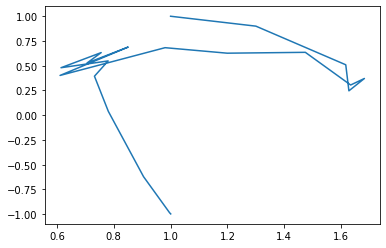

In [0]:
weight_history = np.array(model.weight_history)
plot_2d_space(weight_history)

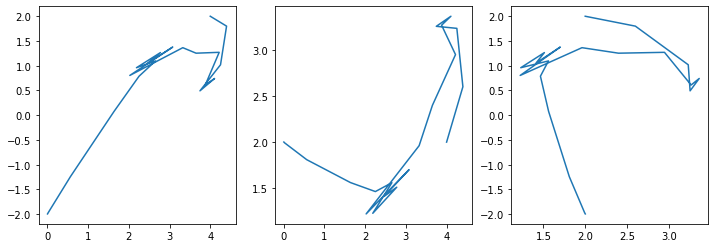

In [0]:
excitation_history = np.array(model.excitation_history)
plot_3d_space(excitation_history)

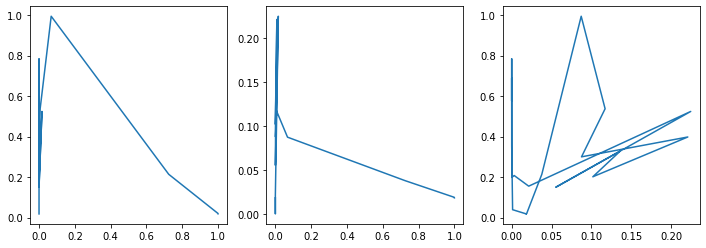

In [0]:
output_history = np.array(model.output_history)
plot_3d_space(output_history)

In [0]:
weight_history[-1]

array([ 1.00041735, -0.99706823])

In [0]:
def plot_history(history, filename):
    with open(DATA_DIR / filename, "w") as f:
        for entry in history:
            f.write("\t".join(map(str, entry)) + "\n")

In [0]:
plot_history(weight_history, "stripe_problem_adaptive_clothoid_weights.dat")
plot_history(excitation_history, "stripe_problem_adaptive_clothoid_excitations.dat")
plot_history(output_history, "stripe_problem_adaptive_clothoid_outputs.dat")